In [323]:
%matplotlib inline

In [324]:
import numpy as np
import pandas as pd

from sklearn import linear_model, metrics
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import LeaveOneOut

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator

from sklearn_pandas import DataFrameMapper

from scipy.optimize import leastsq
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

In [325]:
from tpot import TPOTClassifier
from sklearn.externals import joblib

In [326]:
file_name = 'ceo.xlsx'

In [327]:
df_origin = pd.read_excel(file_name)

In [328]:
df_origin.head()

,salary,totcomp,tenure,age,sales,profits,assets,Unnamed: 7
0,3030,8138,7,61,161315.0,2956.0,257389.0,NaN
1,6050,14530,0,51,144416.0,22071.0,237545.0,NaN
2,3571,7433,11,63,139208.0,4430.0,49271.0,NaN
3,3300,13464,6,60,100697.0,6370.0,92630.0,NaN
4,10000,68285,18,63,100469.0,9296.0,355935.0,NaN


In [329]:
df = df_origin.drop(['Unnamed: 7'], axis=1)

In [330]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,8138,7,61,161315.0,2956.0,257389.0
1,6050,14530,0,51,144416.0,22071.0,237545.0
2,3571,7433,11,63,139208.0,4430.0,49271.0
3,3300,13464,6,60,100697.0,6370.0,92630.0
4,10000,68285,18,63,100469.0,9296.0,355935.0


In [331]:
df["salary"].describe()

count      447.000000
mean      2027.516779
std       1722.566389
min        100.000000
25%       1084.000000
50%       1600.000000
75%       2347.500000
max      15250.000000
Name: salary, dtype: float64

In [332]:
# let's look at the data types
df.dtypes

salary       int64
totcomp      int64
tenure       int64
age          int64
sales      float64
profits    float64
assets     float64
dtype: object

In [333]:
# Let's compute the number of missing values
pd.isnull(df).sum()

salary     0
totcomp    0
tenure     0
age        0
sales      0
profits    0
assets     0
dtype: int64

In [334]:
#dependent variable
target = "salary"

# remaining variables  -features
features = list(df.columns.values)
features.remove(target)

In [335]:
features

[u'totcomp', u'tenure', u'age', u'sales', u'profits', u'assets']

In [336]:
# Standardization
std_scale =  preprocessing.StandardScaler().fit(df[features])
df_features = std_scale.transform(df[features])

In [337]:
df[features] = df_features

In [338]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083


In [339]:
X = df[features]
y = df[target]

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### (c) Run a lasso regression for scaled  data with alpha (0; 1).

In [341]:
alpha = 0.8

In [342]:
lassoreg = Lasso(alpha=alpha)

In [343]:
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)

In [344]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [345]:
mean_absolute_percentage_error(y_test, y_pred)

47.659306806261128

In [346]:
lassoreg.coef_

array([ 416.40645107,  256.68105787,   56.78303056,  323.2845075 ,
         -1.02785237,  489.2021878 ])

In [347]:
coef = lassoreg.coef_
print "y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}*x3 + {:.2f}*x4 + {:.2f}*x5 + {:.2f}*x6".format(coef[0], coef[1], coef[2], coef[3], coef[4], coef[5])

y = 416.41*x1 + 256.68*x2 + 56.78*x3 + 323.28*x4 + -1.03*x5 + 489.20*x6


In [348]:
# Plot the estimated parameters as functions of alpha.

In [349]:
n_alphas = 200
alphas = np.logspace(-4, 0, n_alphas)

coefs = []
for a in alphas:
    lr = Lasso(alpha=a)
    lr.fit(X_train, y_train)
    coefs.append(lr.coef_)

In [350]:
coefs = np.vstack(coefs)

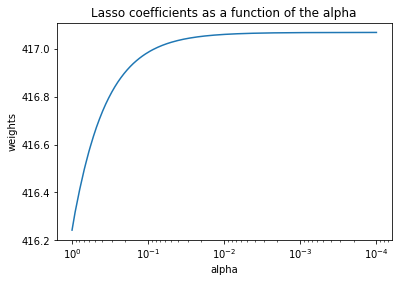

In [351]:
# Display results

ax = plt.gca()

ax.plot(alphas, coefs[:,0])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the alpha')
plt.axis('tight')
plt.show()

In [352]:
# Which value of alpha would you recommend?

In [353]:
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [354]:
lassocv = linear_model.LassoCV(alphas=alphas, normalize=True)
lassocv.fit(X_train, y_train)
lassocv_score = lassocv.score(X_test, y_test)
lassocv_alpha = lassocv.alpha_

In [355]:
lassocv_alpha

1.0

In [356]:
# another approach

In [357]:
tuned_parameters = {'alpha': np.logspace(-10, 0, 5)}
lasso = GridSearchCV(estimator=linear_model.Lasso(),param_grid=tuned_parameters)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
mape = mean_absolute_percentage_error(y_test, lasso_preds)
print 'Lasso mape: {}'.format(mape)

Lasso mape: 47.6555064096


In [358]:
lasso.best_estimator_.alpha

1.0

In [359]:
df_profits_sales = df_origin[df_origin['profits'] >= 0]

In [360]:
log_profits = np.array(np.log(df_profits_sales['profits'].values))
log_sales = np.array(np.log(df_profits_sales['sales'].values))

In [361]:
type(log_sales)

numpy.ndarray

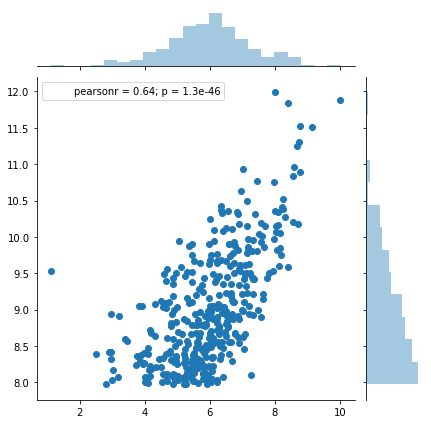

In [362]:
# (a) Make a bivariate scatter plot
sns.jointplot(x=log_profits, y=log_sales)

In [363]:
# Create linear regression object
lregr = linear_model.LinearRegression()

In [364]:
# Train the model using the training sets
lregr.fit(log_sales.reshape(-1, 1), log_profits)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [365]:
# Make predictions using the testing set
lregr_y_pred = lregr.predict(log_sales.reshape(-1, 1))

In [366]:
# The intercept
print('Intercept: ', lregr.intercept_)

('Intercept: ', -3.1210892992114498)


In [367]:
# The coefficients
print('Coefficients: ', lregr.coef_)

('Coefficients: ', array([ 1.01099621]))


In [368]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, lregr_y_pred))

mean absolute percentage_error: 15.12


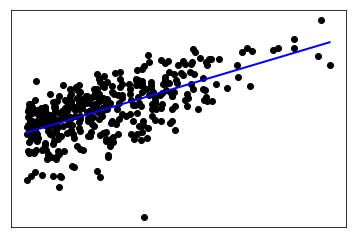

In [369]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()

In [370]:
def func(x, intercept, coeff, power):
    return intercept + coeff * pow(x, power)

popt, pcov = curve_fit(func, log_sales, log_profits, p0=(0.0, 1.0, 2.0))

In [371]:
# the fit parameters
popt

array([ 1.11153934,  0.0890415 ,  1.81832607])

In [372]:
pcov

array([[ 8.74805335, -0.75632962,  3.03321528],
       [-0.75632962,  0.06581633, -0.26439227],
       [ 3.03321528, -0.26439227,  1.06256632]])

In [373]:
func_pred = func(log_sales, popt[0], popt[1], popt[2])

In [374]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, func_pred))

mean absolute percentage_error: 15.11


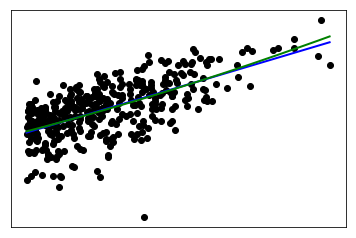

In [375]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)
plt.plot(log_sales.reshape(-1, 1), func_pred, color='green', linewidth=2)
plt.xticks(())
plt.yticks(())

plt.show()

#### 3. Next we model the relationship between log-profits and log-sales using a nonparametric regression.

In [376]:
class KernelRegression(BaseEstimator, RegressorMixin):

    # Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
    #
    # License: BSD 3 clause
    # https://github.com/jmetzen/kernel_regression

    """Nadaraya-Watson kernel regression with automatic bandwidth selection.
    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.
    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.
    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.
    See also
    --------
    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values
        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [377]:
gamma=np.logspace(-2, 2, 10)
param_grid={"C": [1e-1, 1e0, 1e1, 1e2], "gamma": gamma}

In [378]:
# Fit regression models
svr = GridSearchCV(SVR(kernel='rbf'), cv=5, param_grid = param_grid)
nadaraya_watson = KernelRegression(kernel="rbf", gamma=gamma)

In [379]:
svr_pred = svr.fit(log_sales.reshape(-1, 1), log_profits).predict(log_sales.reshape(-1, 1))

In [380]:
nadaraya_watson_pred = nadaraya_watson.fit(log_sales.reshape(-1, 1), log_profits).predict(log_sales.reshape(-1, 1))

In [381]:
# svr error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, svr_pred))

mean absolute percentage_error: 15.21


In [382]:
# nadaraya_watson error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, nadaraya_watson_pred))

mean absolute percentage_error: 14.95


#### 4. We manually classify all CEO into those who earn more than 2000 and those who earn less than 2000.

In [383]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083


In [384]:
df['Ygr2000'] = np.where(df['salary']>2000, 1, 0)

In [385]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets,Ygr2000
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288,1
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042,1
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983,1
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313,1
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083,1


In [386]:
labels = df['Ygr2000']

In [387]:
variables = df[features]

In [388]:
X_train, X_test, y_train, y_test = train_test_split(variables, labels,
                                                    train_size=0.75, test_size=0.25)

In [389]:
cv = 5

In [390]:
estimator = LogisticRegression()

In [391]:
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1']
}

In [392]:
optimizer = GridSearchCV(estimator, param_grid, cv = cv)

In [393]:
optimizer.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [394]:
auc_2 = roc_auc_score(y_test, optimizer.predict(X_test))

In [395]:
auc_2

0.64805194805194799

In [396]:
print('Intercept:', optimizer.best_estimator_.intercept_[0])

('Intercept:', -0.47644605284199176)


In [397]:
print('Coefficient of each feature:', optimizer.best_estimator_.coef_)

('Coefficient of each feature:', array([[ 2.31868307,  0.33511352,  0.00447131,  0.52960753,  0.8730479 ,
         0.54053765]]))


In [398]:
print(pd.DataFrame(np.transpose(optimizer.best_estimator_.coef_),df[features].columns))

                0
totcomp  2.318683
tenure   0.335114
age      0.004471
sales    0.529608
profits  0.873048
assets   0.540538


In [399]:
optimizer.best_estimator_.coef_[0]

array([ 2.31868307,  0.33511352,  0.00447131,  0.52960753,  0.8730479 ,
        0.54053765])

In [400]:
intercept = optimizer.best_estimator_.intercept_[0]
coeffs = df[features].columns
weight = optimizer.best_estimator_.coef_[0]
print "y = {:.2f} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{}".format(intercept, weight[0], coeffs[0], weight[1], coeffs[1], weight[2], coeffs[2], weight[3], coeffs[3], weight[4], coeffs[4], weight[5], coeffs[5])

y = -0.48 + 2.32*totcomp + 0.34*tenure + 0.00*age + 0.53*sales + 0.87*profits + 0.54*assets


In [401]:
#for X_test.iloc[0]
X_test.iloc[0]

totcomp   -0.141647
tenure     0.748474
age       -0.363258
sales     -0.397317
profits   -0.269638
assets    -0.243770
Name: 286, dtype: float64

In [402]:
coeffs = X_test.iloc[0].values
print "y = {:.2f} + {:.2f}*{:.2f} + {:.2f}*{:.2f} + {:.2f}*{:.2f} + {:.2f}*{:.2f} + {:.2f}*{:.2f} + {:.2f}*{:.2f}".format(intercept, weight[0], coeffs[0], weight[1], coeffs[1], weight[2], coeffs[2], weight[3], coeffs[3], weight[4], coeffs[4], weight[5], coeffs[5])

y = -0.48 + 2.32*-0.14 + 0.34*0.75 + 0.00*-0.36 + 0.53*-0.40 + 0.87*-0.27 + 0.54*-0.24


In [403]:
y = -0.38 + 2.02*-0.25 + 0.24*-0.95 + 0.13*-1.69 + 0.52*-0.51 + 0.87*-0.46 + 0.50*-0.39

In [404]:
y

-2.1931

In [405]:
odds = np.exp(y)

In [406]:
# convert from odds to probability:
odds / (1 + odds)

0.1003718248813233

In [407]:
#let's check:
y_test.iloc[0]

0

In [408]:
# another approach
lregrcv = LogisticRegressionCV(cv=10, penalty='l1', solver='liblinear')

In [409]:
lregrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [410]:
auc_2 = roc_auc_score(y_test, lregrcv.predict(X_test))

In [411]:
auc_2

0.64805194805194799

In [412]:
print('Intercept:', lregrcv.intercept_[0])

('Intercept:', -0.48021547245974883)


In [413]:
print('Coefficient of each feature:', lregrcv.coef_)

('Coefficient of each feature:', array([[ 2.25905992,  0.33273361,  0.00245955,  0.52314542,  0.86826607,
         0.53519715]]))


In [414]:
print(pd.DataFrame(np.transpose(lregrcv.coef_),df[features].columns))

                0
totcomp  2.259060
tenure   0.332734
age      0.002460
sales    0.523145
profits  0.868266
assets   0.535197


In [415]:
# after l1 regularization we have all non-zero coefficients. so - keep them all

In [416]:
np.random.seed(3)

# number of rows
remove_n = 5

# pick up random CEO from test and get it's indices
randCEO_indices = np.random.choice(X_test.index, remove_n, replace=False)
randCEO_indices

array([291,  23, 426, 421, 316], dtype=int64)

In [417]:
# actual class
y_test.loc[randCEO_indices]

291    1
23     1
426    0
421    0
316    0
Name: Ygr2000, dtype: int32

In [418]:
# predicted class
optimizer.predict(X_test.loc[randCEO_indices]).reshape(-1,1)

array([[0],
       [1],
       [0],
       [0],
       [0]])

In [419]:
# Determine their probabilities of having the salary of less , or more  than 2000:
optimizer.predict_proba(X_test.loc[randCEO_indices])

array([[ 0.8857877 ,  0.1142123 ],
       [ 0.41447656,  0.58552344],
       [ 0.82297542,  0.17702458],
       [ 0.8334447 ,  0.1665553 ],
       [ 0.90244084,  0.09755916]])

In [420]:
# * first column is the probability that CEO has less than 2000

In [421]:
#Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [422]:
print(classification_report(y_test, optimizer.predict(X_test)))

             precision    recall  f1-score   support

          0       0.77      0.90      0.83        77
          1       0.64      0.40      0.49        35

avg / total       0.73      0.74      0.72       112



In [423]:
print(classification_report(y_test, lregrcv.predict(X_test)))

             precision    recall  f1-score   support

          0       0.77      0.90      0.83        77
          1       0.64      0.40      0.49        35

avg / total       0.73      0.74      0.72       112



In [424]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, optimizer.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

In [425]:
thresholds

array([2, 1, 0])

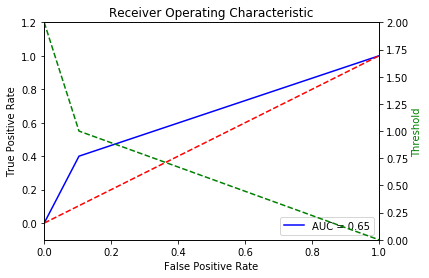

In [426]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()

In [427]:
# as I known, python does not have function like coords for best treshold

#### 5. In the next step we model the salary of CEOs using regression trees.

In [428]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 12],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt_estimator = DecisionTreeClassifier()
dt_opt = GridSearchCV(estimator=dt_estimator, param_grid=param_grid, cv = cv)

In [429]:
dt_opt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10, 12], 'max_leaf_nodes': [None, 5, 10, 20], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [430]:
tree_model = dt_opt.best_estimator_
print (dt_opt.best_score_, dt_opt.best_params_)

(0.76417910447761195, {'min_samples_split': 2, 'max_leaf_nodes': 5, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1})


In [431]:
roc_auc_score(y_test, tree_model.predict(X_test))

0.73766233766233757

In [432]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tree_model.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

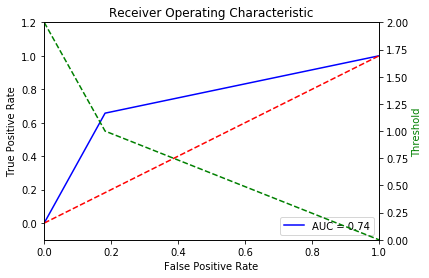

In [433]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()

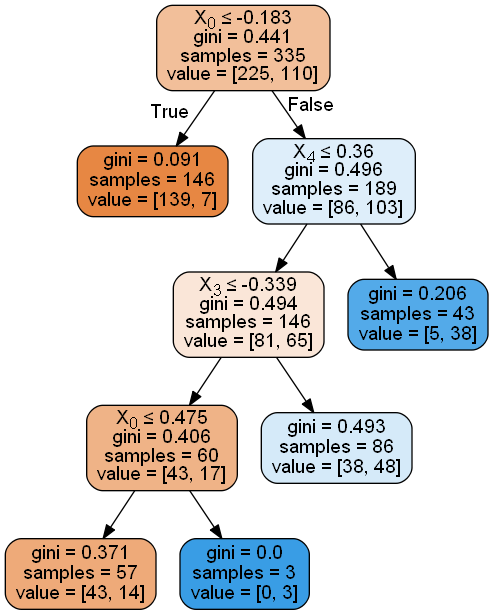

In [434]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [435]:
# Another approach
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=100.0, fit_prior=True)),
    DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, min_samples_split=5)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [436]:
roc_auc_score(y_test, exported_pipeline.predict(X_test))

0.74805194805194808

In [437]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, exported_pipeline.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

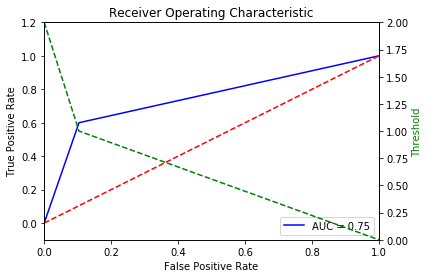

In [438]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()